In [2]:
# Importing necessities for the analysis
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb


In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("max_colwidth", None)

In [4]:
# Loading the data
df_churn=pd.read_csv('../data/Churn_prepared.csv')

In [5]:
df_churn.set_index('customerID', inplace=True)

We are going to train a simple model for prediction,Logistic regression is a simple and quick linear model.
Since our data is not very complex or has high dimensions this model can be a good start.
If we are not satisfied with the result we can experiment and compare with more sophisticated models like, random forest, ridge regression, boosting classifiers(XgBoost,LightGBM or CatBoost) or a simple Multi Layer Preceptron(MLP).


now we can start the model training and eval. At this point based on our knwledge of the data structure we need to make some decisions on what evaluation strategy we are going to use.

-Train-Test Split:

    The most simple method would be to use a train-test split on the data. I gives an estimate of how well the model performs on unseen data.
    However, a simple split can generate problems. Since the split is random, it's possible that the model will be evaluated on a sample that is easier or more difficult to predict, we can get a misleading estimate of model performance.

-Cross-Validation:

    Instead of simple train-test split, I prefer to use cross-validation most of the time. We train the model on different subsets (or "folds") of the data and evaluate it separately on the remaining portion. Then we aggregate the results, usually we a more reliable estimate of how the model will perform on new data.

-Stratified Cross-Validation:

    In our dataset, the target variable (Churn) is imbalanced, meaning that the distribution between the positive class (customers who churn) and the negative class (customers who do not churn) is not close to equal, there are more customers who do not churn than those who do.
    For imbalanced datasets, it is advised to use stratified cross-validation. With this method each fold represents the class distribution of the full dataset.



In [6]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Defining features and target
X = df_churn.drop(columns=['Churn'])  
y = df_churn['Churn']

# Feature scaling (Logistic regression is sensitive to feature scales)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Defining the model
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# Perform cross-validation
cv_scores = cross_val_score(log_reg, X_scaled, y, cv=skf, scoring='accuracy')

# Print cross-validation results
print("Cross-Validation Scores:", cv_scores)
print("Mean Cross-Validation Score:", cv_scores.mean())

# Now, to fit the model on the entire dataset
log_reg.fit(X_scaled, y)

# Making predictions on the same dataset (for consistency in this scenario)
y_pred = log_reg.predict(X_scaled)

# Confusion Matrix and Classification Report (evaluate model performance)
print("\nConfusion Matrix:")
print(confusion_matrix(y, y_pred))

print("\nClassification Report:")
print(classification_report(y, y_pred))


Cross-Validation Scores: [0.73740241 0.75088715 0.75088715 0.75497159 0.73863636]
Mean Cross-Validation Score: 0.7465569351248468

Confusion Matrix:
[[3767 1407]
 [ 361 1508]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      5174
           1       0.52      0.81      0.63      1869

    accuracy                           0.75      7043
   macro avg       0.71      0.77      0.72      7043
weighted avg       0.81      0.75      0.76      7043



# EVALUATION

- Accuracy:

        The model is able to correctly predict around 74.66% of the labels on average.

- Confusion matrix:

        True Negatives (TN): 3767 (Predicted as 0, and true class is 0)
        False Positives (FP): 1407 (Predicted as 1, but true class is 0)
        False Negatives (FN): 361 (Predicted as 0, but true class is 1)
        True Positives (TP): 1508 (Predicted as 1, and true class is 1)

 The model makes more False Positives  mistakes, meaning that it incorrectly predicts some customers as churners when they are not.  False Negatives —customers who will churn but are predicted to stay—are generally more costly. Missing churners means the business loses an opportunity to retain them. Reducing False Negatives is more important.
 
- Precision:

        High precision for class 0 (91%) suggests that the model is good in identifying non-churners. 
        Lower precision for class 1 (52%) indicates that the model makes more mistakes in predicting churners (more important).


- Recall:

        Recall for class 0 is 73%, meaning most non-churners are correctly identified. 
        Higher recall for class 1 (81%) indicates that the model is fairly good at identifying churners but could still be improved.


- F1 Score:

        Balances precision and recall. Need to improve 0 class prediction.

- Support:

        Shows the distribution of classes in the test data



At this point we can decide if the results are satisfing and we keep the current model, or we want to improve the predictions. There are many ways to try and do this:

   - We can experiment with different classifiers, for example random forest classifier, more complex boosting models(xgb,lgb or catboost) or a MPL(a simple neural network)

    - We can engineer new features based on our knowledge of the subject or interaction features with the combination of already existing features.

    - We can use model hyperparameter optimization methods like gridsearch or a more sophisticated optuna study.

    - We can use ensemble methods to combine the strength o different models with bagging or stacking, or we can use blending of multiple predictions.

    - We can use platt scaling or isotonic regression to calibrate the probability outputs of the models, or tune tresholds of label predicitons.



# How to turn the results into value?


Example 1

In [7]:
# Predict the probas 
y_pred_proba = log_reg.predict_proba(X_scaled)[:, 1]

# new df with id, predicted probability and true label(just for verification)
churn_with_probas=df_churn[['Churn']].copy()
churn_with_probas['predicted_probability']=y_pred_proba


churn_with_probas.sort_values('predicted_probability',ascending=False).head(20)

,Churn,predicted_probability
customerID,,
9497-QCMMS,1,0.936493
9300-AGZNL,1,0.935973
7024-OHCCK,1,0.935178
4424-TKOPW,1,0.934653
2720-WGKHP,1,0.934210
5178-LMXOP,1,0.933892
5150-ITWWB,0,0.932539
1374-DMZUI,1,0.932417
5567-WSELE,1,0.931014



- With this method we can find the customers that are most likely to churn(highest proba)
- we can expect the model to perform similarly on unseen data (in 20 predictions 2 mistakes)
- The model usually will perform better in edge cases (very high or low probability of churn)
- The company can reach out to the custmers with ris of churn and try to retain them.

Example 2

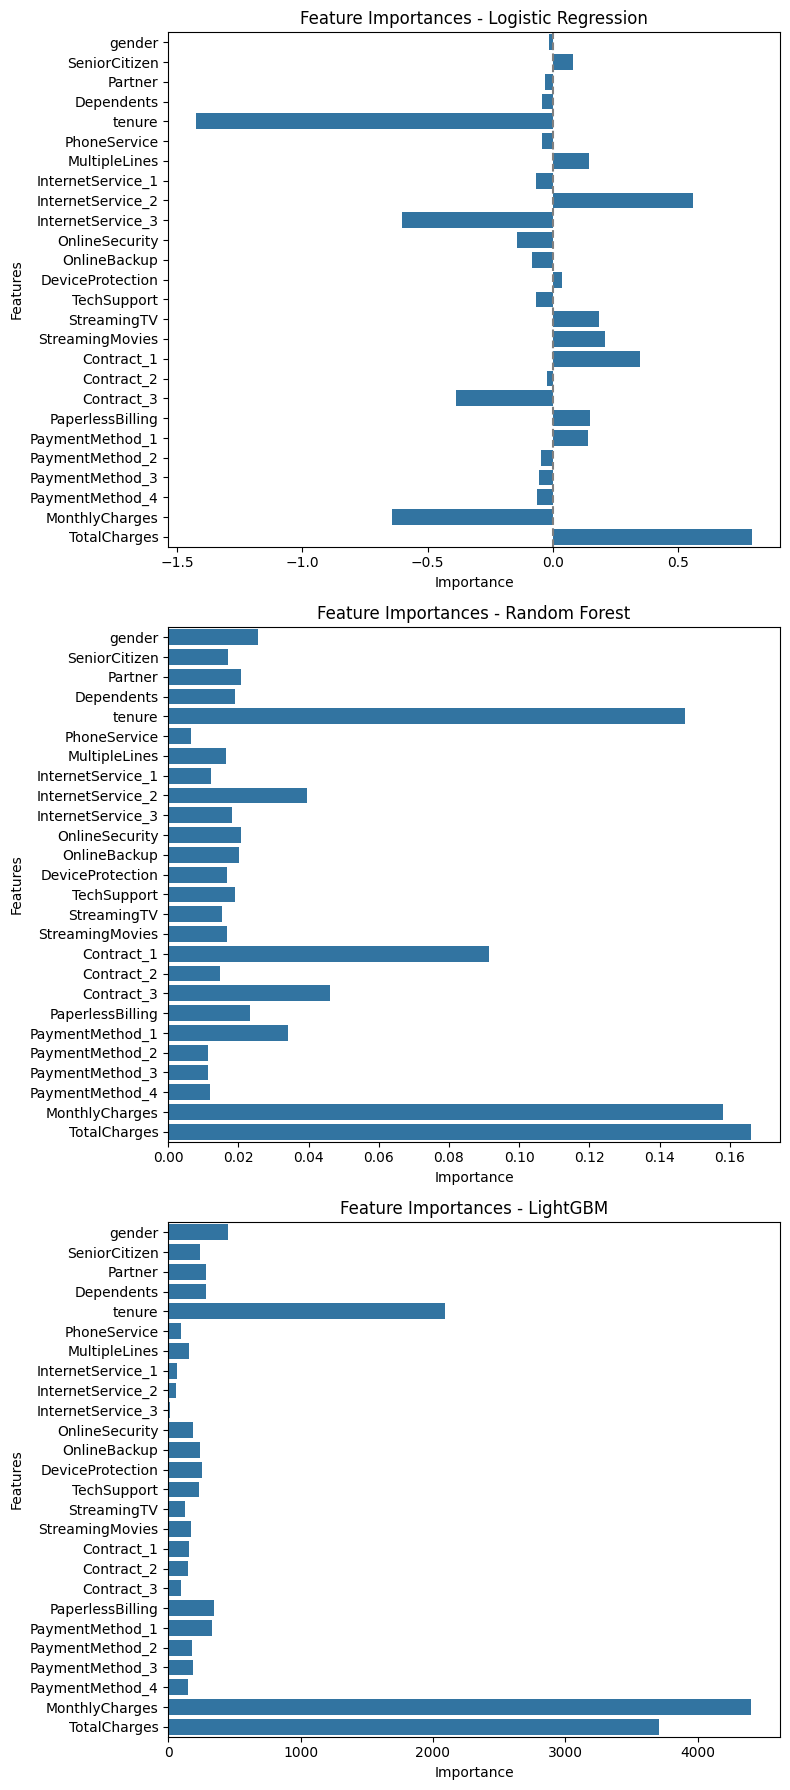

In [12]:

# Features and target
X = df_churn.drop(columns=['Churn'])  
y = df_churn['Churn']

# Scaleing for logreg models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1, stratify=y)

# Models with basic params
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced')
random_forest = RandomForestClassifier(n_estimators=600, max_depth=25, class_weight='balanced')
lgbm = lgb.LGBMClassifier(n_estimators=600, learning_rate=0.1, max_depth=6, metric='f1',verbose=-1)

# Fit the models on the training data
models = [log_reg,random_forest, lgbm]
model_names = ['Logistic Regression', 'Random Forest', 'LightGBM']

# dictionary for feature importances
feature_importances = {}

for model, name in zip(models, model_names):
    model.fit(X_train, y_train)
    
    if name=='Logistic Regression': 
        feature_importances[name] = model.coef_[0]
    else :  
        feature_importances[name] = model.feature_importances_

# Convert the feature importances dictionary into a DataFrame
importance_df = pd.DataFrame(feature_importances, index=X.columns)

# Plotting feature importances
num_models = len(model_names)
plt.figure(figsize=(8, 6 * num_models))

for i, name in enumerate(model_names):
    plt.subplot(num_models, 1, i + 1)  # subplot for each model
    sns.barplot(x=importance_df[name], y=importance_df.index)
    plt.title(f'Feature Importances - {name}')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.axvline(0, color='gray', linestyle='--')  

plt.tight_layout() 
plt.show()


- The importances can help us understand what features were most influencial for the models.
- This can help the company to understand better the aspects that influence churn and identify possible targets for marketing campaignes.